In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving Data Analyst Challenge.xlsx to Data Analyst Challenge.xlsx


In [ ]:

customers_df = pd.read_excel("Data Analyst Challenge.xlsx", sheet_name='Customers', engine='openpyxl')
sales_df = pd.read_excel("Data Analyst Challenge.xlsx", sheet_name='Sales', engine='openpyxl')


In [ ]:
#  merge and analyze
merged_df = pd.merge(customers_df, sales_df, on='CustomerID')

In [ ]:
merged_df.head()

,CustomerID,First Name,Last Name,Address,Address 2,City,State,Zip,SKU,Price,Tax,Store,TransactionID,Descr,Class,Category
0,25028575,BRENDA,LEWIS,53535 N FRANK LLOYD WRIGHT BLVD UNIT 3813,NaN,WEST PALM BCH,FL,78052-1389,8193459415,22.0,1.32,D025,108041,SIL ABCS 7 1/4 STARTER BRACELET,Carriers & Clasps,Charms
1,25028575,BRENDA,LEWIS,53535 N FRANK LLOYD WRIGHT BLVD UNIT 3813,NaN,WEST PALM BCH,FL,78052-1389,8193431030,8.5,0.51,D025,108041,SIL/STN/ENM ABC CHAMPAGNE CH,Charms,Charms
2,25028575,BRENDA,LEWIS,53535 N FRANK LLOYD WRIGHT BLVD UNIT 3813,NaN,WEST PALM BCH,FL,78052-1389,8193471599,6.5,0.39,D025,108041,SIL/STN ABC COSMIC HEART SPR,"Stones, beads, spacers",Charms
3,25028575,BRENDA,LEWIS,53535 N FRANK LLOYD WRIGHT BLVD UNIT 3813,NaN,WEST PALM BCH,FL,78052-1389,8193471599,6.5,0.39,D025,108041,SIL/STN ABC COSMIC HEART SPR,"Stones, beads, spacers",Charms
4,9938001083,WENDY,RUETER,388 N STATE HIGHWAY 368 APT 5751 APT 5751,NaN,ARVADA,CO,17268-9372,8193432074,18.0,1.48,D121,10025,SIL/STN TWINKLE MINI PST EAR,Mini Posts,Jewelry


In [ ]:
# Frequency: Number of transactions per customer
# Calculate Frequency based on unique Transaction IDs per CustomerID
frequency_df = merged_df[['CustomerID', 'TransactionID']].drop_duplicates().groupby("CustomerID").size().reset_index(name="Frequency")
# Monetary: Total spend per customer
monetary_df = merged_df.groupby("CustomerID")["Price"].sum().reset_index(name="Monetary")
# Merge frequency and monetary data
rfm_df = pd.merge(customers_df[['CustomerID', 'First Name', 'Last Name']], frequency_df, on="CustomerID")
rfm_df = pd.merge(rfm_df, monetary_df, on="CustomerID")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Normalize metrics for clustering
# Select only the RFM columns for scaling
rfm_scaled = rfm_df[[ 'Frequency', 'Monetary']]
scaler = MinMaxScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_scaled), columns=rfm_scaled.columns)


In [ ]:
# Merge normalized data back to main DataFrame
rfm_df_normalized = pd.concat([rfm_df[['CustomerID', 'First Name', 'Last Name']], rfm_normalized], axis=1)

# Display the normalized RFM DataFrame
rfm_df_normalized.head()

,CustomerID,First Name,Last Name,Frequency,Monetary
0,25028575,BRENDA,LEWIS,0.000000,0.003241
1,9938001083,WENDY,RUETER,0.009174,0.003437
2,126000698,LISA,MASK,0.000000,0.017027
3,60011947,ANGELI,HOOVER,0.009174,0.022729
4,61007939,JOAN,TAYLOR,0.027523,0.012262


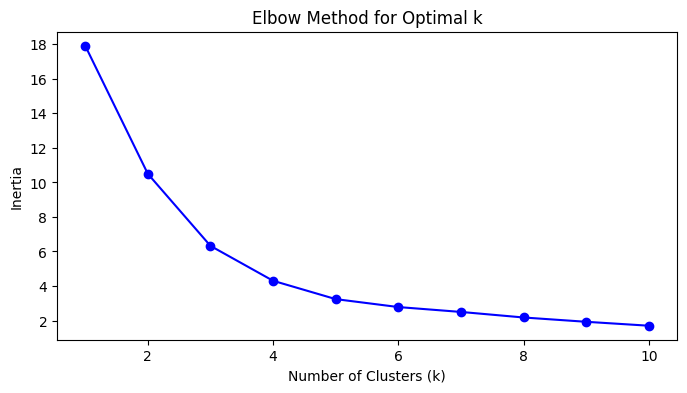

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Use the Elbow Method to determine optimal number of clusters (k)
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Apply K-means clustering with an optimal k value, which is 3 for this algorithm based off the elbow method
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_normalized)

In [ ]:
# Generate a sample list for each segment (cluster)
# This selects 5 random customers from each cluster to create a representative sample list
sample_customers = rfm_df.groupby('Cluster').apply(lambda x: x.sample(5, random_state=42)).reset_index(drop=True)

# Display the sample customer list for each segment
print("Sample Customer List by Segment")
sample_customers

Sample Customer List by Segment


<ipython-input-27-b3c110453e6a>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_customers = rfm_df.groupby('Cluster').apply(lambda x: x.sample(5, random_state=42)).reset_index(drop=True)


,CustomerID,First Name,Last Name,Frequency,Monetary,Recency,Cluster
0,9937033904,BEVERLY,MONTAGNE,3,214.00,3,0
1,28011629,VERONICA,CHAFFIN,3,268.00,3,0
2,9907007203,SARAH,HART,1,146.00,1,0
3,45011022,ELIZABETH,TRUMBLY,4,190.00,4,0
4,54016781,STEPHANIE,O'DONNAL,1,146.00,1,0
5,112000165,LORRAINE,BURNICLE,5,917.98,5,1
6,9935027594,FRANCES,BELMARES,8,636.50,8,1
7,15082672,MARTHA,HARDCASTLE,12,740.00,12,1
8,9935027483,DOLORES,DRESSER,9,1048.98,9,1
9,105006708,CHRISTINE,HATT,6,661.50,6,1


In [ ]:
# Cluster 0 : (Low Frequency, Low Monetary)
# Cluster 1 : (High Frequency, Moderate Monetary)
# Cluster 2 : (High Frequency, High Monetary)